### making importation for modules

In [356]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### loading data for test and train

In [4]:
train_df = pd.read_csv('train_set.csv')
test_df = pd.read_csv('test_set.csv')

### Exploring Data 

In [5]:
# checking for classification type
train_df['lang_id'].unique()

array(['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso',
       'sot', 'afr'], dtype=object)

In [7]:
#creating simple countplot
# from the plot below seem we have balanced classes for our clasification
fig = px.histogram(train_df, x="lang_id", color="lang_id") 
fig.show()

In [8]:
#checking for null values in train 
train_df.isna().sum()

lang_id    0
text       0
dtype: int64

In [9]:
#checking for null values in test 
test_df.isna().sum()

index    0
text     0
dtype: int64

In [10]:
#checking for number for each language  values in train 
train_df['lang_id'].value_counts()

lang_id
xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: count, dtype: int64

### Feature engineering

In [142]:
from collections import Counter
from nltk import ngrams
from nltk.tokenize import  TreebankWordTokenizer

Lets start with data cleaning for our `train data set` and `test data set`

In [174]:
# function for removing punctuations and numbers
import string
print ('Cleaning punctuation and numbers from our text data...')
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])


Cleaning punctuation and numbers from our text data...


In [173]:
# applying the function to remove punctuation and numbers
train_df['clean_text']=train_df['text'].apply(remove_punctuation_numbers)
test_df['clean_text']=test_df['text'].apply(remove_punctuation_numbers)

In [179]:
# Make lower case for text 
print ('Lowering case in the data set...')
test_df['clean_text']= test_df['clean_text'].str.lower()
train_df['clean_text']= train_df['clean_text'].str.lower()

Lowering case in the data set...


In [178]:
## Remove urls from our text 
print ('Removing URLs from our text...')
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
test_df['clean_text'] = test_df['clean_text'].replace(to_replace = pattern_url, value = subs_url, regex = True)
train_df['clean_text'] = train_df['clean_text'].replace(to_replace = pattern_url, value = subs_url, regex = True)

Removing URLs from our text...


In [180]:
# declaring a tokeniser
tokeniser = TreebankWordTokenizer()

In [182]:
# joing all text together in train data
texttrain=" ".join(train_df['clean_text'])
tokentrain=tokeniser.tokenize(texttrain)
bowtrain=Counter(tokentrain)

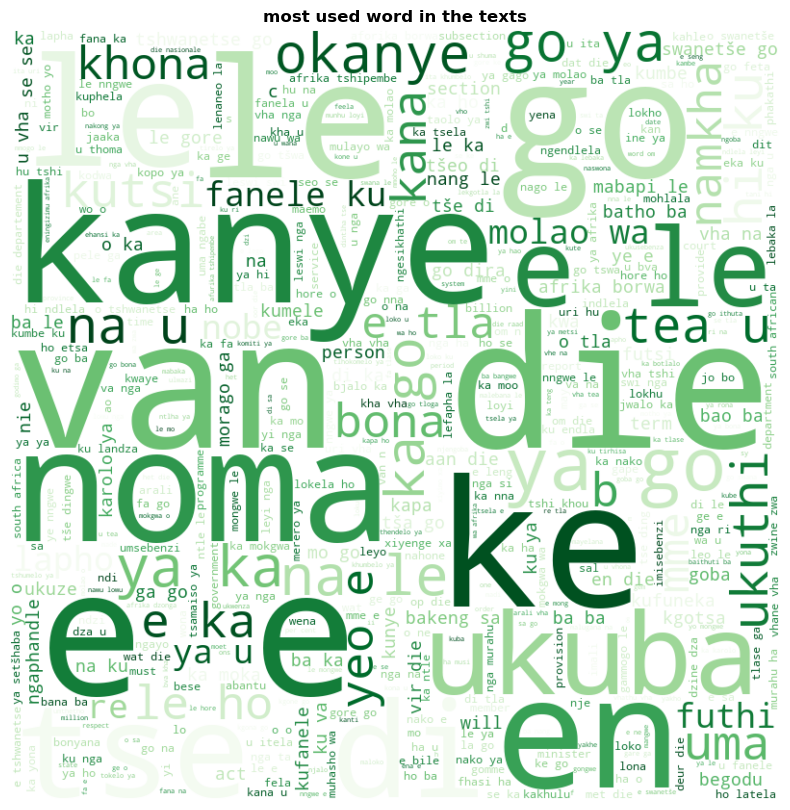

In [358]:
# Create a WordCloud plot for most popular words in the text 
plt.figure(figsize=(10, 10))
plt.title("most used word in the texts", fontweight='bold')
pop_words = WordCloud(background_color="white", max_words=500, max_font_size=300, width=800, height=800)
pop_words.generate(texttrain)
plt.imshow(wc_anti.recolor(colormap='Greens', random_state=17), interpolation="bilinear")
plt.axis('off')
plt.show()

Here am declaring low frequency words ie those that have been used once.These words
could be `typos` and are not recommded for machine learning

In [359]:

wordtrain=pd.DataFrame(bowtrain.items(),columns=['word','frequency']).sort_values(by='frequency')
#less frequency words
lessfreq=wordtrain[wordtrain['frequency']<2]
word_less_freq=lessfreq['word'].values.tolist()

#high frequency words 
highfreq=wordtrain[wordtrain['frequency']>2000]
word_high_freq=highfreq['word'].values.tolist()


In [261]:
#removing low frequency word ie word that appear less than 2 times in the corpus
def rem_low_freq_train(text):
      # Lowercase text
    token = tokeniser.tokenize(text)
    text = " ".join([l for l in token if l not in word_less_freq])
    return text 

In [262]:
#removing high frequency word ie word  that appear more than 3000 times in the corpus
def rem_high_freq_train(text):
      # Lowercase text
    token = tokeniser.tokenize(text)
    text = " ".join([l for l in token if l not in word_high_freq])
    return text 

In [264]:
train_df['clean_text']=train_df['clean_text'].apply(rem_low_freq_train)
test_df['clean_text']=test_df['clean_text'].apply(rem_low_freq_train)

In [330]:
#
train_df['clean_text']=train_df['clean_text'].apply(rem_high_freq_train)
test_df['clean_text'] = test_df['clean_text'].apply(rem_high_freq_train)

In [331]:
## extracting new features using TFIDF vectoriser     
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(train_df['clean_text'])

# applying the features extracted in train data to test data
X_test_set = vectorizer.transform(test_df['clean_text'])



In [332]:
X.shape

(33000, 571471)

In [324]:
from sklearn import preprocessing
## encoding the y labels ie lang_id
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
train_df['lang_id_no']= label_encoder.fit_transform(train_df['lang_id']) 

In [325]:
y=train_df['lang_id_no']
#train_df['lang_id_no'].unique()

In [333]:
from sklearn.model_selection import train_test_split
# using the train test split function  to split my test and train data
X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=100, test_size=0.10,shuffle=True) 

### Modelling

👍Here i will be training my models and picking the best model for my prediction. I will be training my models on 
- RandomForest Classifier
- support Vector Classifier
- LGBM classifier

In [252]:
## creating models for  my classification task
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier


##### This is my Random forest classifier

In [339]:

rf=RandomForestClassifier(n_estimators=30,random_state=25)
rf.fit(X_train,y_train)
y_rf_pred=rf.predict(X_test)

##### This is my Support Vector Classifier

In [337]:
svc = SVC(kernel='rbf',C=10)
svc.fit(X_train,y_train)


SVC(C=10)

In [353]:
y_svc_pred=svc.predict(X_test)


##### This is my LGBM classifier

In [341]:
model = LGBMClassifier(learning_rate=0.1, n_estimators=100,num_class= 11)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.906253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141302
[LightGBM] [Info] Number of data points in the train set: 29700, number of used features: 6269
[LightGBM] [Info] Start training from score -2.393461
[LightGBM] [Info] Start training from score -2.399007
[LightGBM] [Info] Start training from score -2.398636
[LightGBM] [Info] Start training from score -2.397525
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.409069
[LightGBM] [Info] Start training from score -2.400491
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.394937
[LightGBM] [Info] Start training from score -2.399007
[LightGBM] [Info] Start training from score -2.389046


LGBMClassifier(num_class=11)

In [354]:
y_lgbm_pred=model.predict(X_test)

In [380]:
#we will try selecting important features
#from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#sfs = sfs(svc1, k_features=500000, forward=True, scoring='f1', cv=10)

In [346]:
#sfs.fit(X_train,y_train)
#y_pred_svc_train=sfs.predict(X_test)

# 🚚 Model Performance

Here are my models performance report
- RandomForest Classifier
- Support Vector Classifier
- LGBMclassifier

#### RandomForest Classifier perfomance report

In [343]:
print('...................RandomForest Classifier...............')
print(metrics.classification_report(y_test, y_rf_pred))
print('...........................................................')

...................RandomForest Classifier...............
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       288
           1       0.98      1.00      0.99       303
           2       0.99      0.94      0.97       302
           3       1.00      0.99      0.99       299
           4       1.00      1.00      1.00       300
           5       0.99      0.98      0.99       330
           6       0.99      0.99      0.99       307
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       292
           9       0.94      0.96      0.95       303
          10       0.93      0.96      0.94       276

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300

...........................................................


In [344]:
print('...................support Vector Classifier Report................')
print(metrics.classification_report(y_test, y_svc_pred))
print('...................................................................')

...................support Vector Classifier Report................
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       288
           1       1.00      1.00      1.00       303
           2       1.00      0.98      0.99       302
           3       1.00      1.00      1.00       299
           4       1.00      1.00      1.00       300
           5       1.00      1.00      1.00       330
           6       1.00      1.00      1.00       307
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       292
           9       0.98      1.00      0.99       303
          10       0.98      0.99      0.99       276

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300

...................................................................


In [355]:
print('...................LGBM Classifier Report...................')
print(metrics.classification_report(y_test, y_lgbm_pred))
print('..............................................................')

...................LGBM Classifier Report...................
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       288
           1       0.99      1.00      0.99       303
           2       0.99      0.97      0.98       302
           3       0.99      0.98      0.98       299
           4       1.00      0.99      0.99       300
           5       0.97      0.98      0.98       330
           6       0.98      1.00      0.99       307
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       292
           9       0.96      0.96      0.96       303
          10       0.94      0.95      0.95       276

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300

..............................................................


In [347]:
#here am predicting the outcome from test data set using my best model which is SVC
y_pred_svc_test=svc.predict(X_test_set)

In [348]:
# here am decoding to original classes i had before  training in my predicted labes
decoded_y_label=label_encoder.inverse_transform(y_pred_svc_test)

In [349]:
# convert numpy array to dataframe 
df = pd.DataFrame(decoded_y_label, columns =['lang_id']) 
df['index'] = range(1, len(df) + 1)
df

lang_id  index
0        tsn      1
1        nbl      2
2        ven      3
3        ssw      4
4        afr      5
...      ...    ...
5677     eng   5678
5678     nso   5679
5679     sot   5680
5680     sot   5681
5681     xho   5682

[5682 rows x 2 columns]

In [350]:
# reordering the columns so that the index becomes the first column
df = df[['index'] + [col for col in df.columns if col != 'index']]
df.reset_index(drop=True, inplace=True)
df

index lang_id
0         1     tsn
1         2     nbl
2         3     ven
3         4     ssw
4         5     afr
...     ...     ...
5677   5678     eng
5678   5679     nso
5679   5680     sot
5680   5681     sot
5681   5682     xho

[5682 rows x 2 columns]

In [352]:
# creatting a submission file to submit to kaggle
submission=df
submission.to_csv('submissionsvc1.csv',index=False)
submission

index lang_id
0         1     tsn
1         2     nbl
2         3     ven
3         4     ssw
4         5     afr
...     ...     ...
5677   5678     eng
5678   5679     nso
5679   5680     sot
5680   5681     sot
5681   5682     xho

[5682 rows x 2 columns]

# Model Explanation

my best model for my language classification task is SVC

#### What is SVC in Machine Learning?
SVC is a supervised learning algorithm that can be used for both classification and regression problems. The function of SVC is to find the optimal hyperplane that can separate the given data into different classes. SVC can be considered as an extension of the Support Vector Machine (SVM) algorithm.

#### The Benefits of SVC in Machine Learning
SVC, or Support Vector Classifier, is a powerful tool in machine learning. It is used to classify data into categories, and has been shown to be accurate and efficient. There are many benefits of using SVC in machine learning, including its ability to handle large datasets, its flexibility, and its ability to create non-linear decision boundaries.

#### How SVC in Machine Learning Works
SVC is a supervised learning algorithm that can be used for both classification and regression tasks. The algorithm works by finding the best decision boundary for the data, which is the line or hyperplane that separates the “classes” in the data.

The algorithm builds a model based on training data, and then makes predictions on new data points. The predictions are made by looking at the decision boundary and seeing which side of the boundary the new data point falls on.

#### The Applications of SVC in Machine Learning
The Support Vector Classifier, or SVC, is a machine learning algorithm that can be used for both binary classification and multiclass classification. In binary classification, the SVC algorithm predicts whether an observation belongs to one class or the other, whereas in multiclass classification, the SVC algorithm predicts which of several classes an observation belongs to. The SVC algorithm can be used with any combination of linear and nonlinear features; however, it is most commonly used with linear features.

The SVC algorithm works by finding the hyperplane that maximizes the margin between the two classes. The margin is defined as the distance between the two closest points from each class. The support vector is the point on the hyperplane that is closest to each of the two classes. The SVC algorithm seeks to find the support vector that maximizes the margin between the two classes.


cited from "https://reason.town/what-is-svc-in-machine-learning/"